In [308]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

# Half Cheetah Results

In [309]:
cheetah_cpo_0 = pd.read_csv('./results/cheetah_cpo_seed0.csv')
cheetah_cpo_1 = pd.read_csv('./results/cheetah_cpo_seed1.csv')
cheetah_cpo_2 = pd.read_csv('./results/cheetah_cpo_seed2.csv')
cheetah_cpo_3 = pd.read_csv('./results/cheetah_cpo_seed3.csv')
cheetah_cpo_4 = pd.read_csv('./results/cheetah_cpo_seed4.csv')

cpo_list = [cheetah_cpo_0, cheetah_cpo_1, cheetah_cpo_2, cheetah_cpo_3, cheetah_cpo_4]

cheetah_cpo_rewards = [results['Metrics/EpRet'] for results in cpo_list]
cheetah_cpo_costs = [results['Metrics/EpCost'] for results in cpo_list]

cheetah_cpo_mean_rewards = np.mean(cheetah_cpo_rewards, axis=0)
cheetah_cpo_mean_costs = np.mean(cheetah_cpo_costs, axis=0)

cheetah_cpo_std_rewards = np.std(cheetah_cpo_rewards, axis=0)
cheetah_cpo_std_costs = np.std(cheetah_cpo_costs, axis=0)

In [310]:
def aggregate_metrics(results_list, task_sequence, task_length):
    nominal_costs, back_costs, front_costs = [], [], []
    nominal_forgets, back_forgets, front_forgets = [], [], []
    nominal_rewards, back_rewards, front_rewards = [], [], []
    for result in results_list:
        nominal_cost, back_cost, front_cost, nominal_forget, back_forget, front_forget, nominal_rew, back_rew, front_rew = calculate_metrics(result, task_sequence, task_length)
        nominal_costs.append(nominal_cost)
        back_costs.append(back_cost)
        front_costs.append(front_cost)
        nominal_forgets.append(nominal_forget)
        back_forgets.append(back_forget) 
        front_forgets.append(front_forget)
        nominal_rewards.append(nominal_rew)
        back_rewards.append(back_rew)
        front_rewards.append(front_rew)

    print("COSTS:")
    print(f'Nominal total costs: {np.mean(nominal_costs)} +/- {np.std(nominal_costs)}')
    print(f'Back total costs: {np.mean(back_costs)} +/- {np.std(back_costs)}')
    print(f'Front total costs: {np.mean(front_costs)} +/- {np.std(front_costs)}')

    print("FORGETTING RATIO:")
    print(f'Nominal forgetting: {np.mean(nominal_forgets)} +/- {np.std(nominal_forgets)}')
    print(f'Back forgetting: {np.mean(back_forgets)} +/- {np.std(back_forgets)}')
    print(f'Front forgetting: {np.mean(front_forgets)} +/- {np.std(front_forgets)}')

    print("REWARDS:")
    print(f'Nominal rewards: {np.mean(nominal_rewards)} +/- {np.std(nominal_rewards)}')
    print(f'Back rewards: {np.mean(back_rewards)} +/- {np.std(back_rewards)}')
    print(f'Front rewards: {np.mean(front_rewards)} +/- {np.std(front_rewards)}')

def calculate_metrics(results, task_sequence, task_length):
    results = add_task_names(results, task_sequence, task_length)
    nominal_cost, back_cost, front_cost = all_average_total_costs(results, task_length)
    nominal_forget, back_forget, front_forget = all_forgetting(results, task_length)
    nominal_rew, back_rew, front_rew = all_rewards(results, task_length)
    return nominal_cost, back_cost, front_cost, nominal_forget, back_forget, front_forget, nominal_rew, back_rew, front_rew

def add_task_names(results, task_sequence, task_length):
    task_names = [[task] * task_length for task in task_sequence]
    task_names = np.concatenate(task_names)
    results['task'] = task_names

    return results

def all_average_total_costs(results, task_length):
    nominal_cost = average_total_costs(results, 'nominal', task_length)
    back_cost = average_total_costs(results, 'back', task_length)
    front_cost = average_total_costs(results, 'front', task_length)

    return nominal_cost, back_cost, front_cost

def average_total_costs(results, task_name, task_length):
    task_results = results[results['task'] == task_name]
    task_costs = task_results['Metrics/EpCost'].to_numpy()

    num_visited = int(len(task_costs) / task_length)

    total_costs = []
    for i in range(num_visited):
        task_idx = np.arange(0, task_length) + i * task_length
        total_costs.append(task_costs[task_idx].sum())

    return np.mean(total_costs)

def all_forgetting(results, task_length):
    nominal_forget = forgetting(results, 'nominal', task_length)
    back_forget = forgetting(results, 'back', task_length)
    front_forget = forgetting(results, 'front', task_length)

    return nominal_forget, back_forget, front_forget

def forgetting(results, task_name, task_length):
    task_results = results[results['task'] == task_name]
    task_rewards = task_results['Metrics/EpRet'].to_numpy()

    endpoint = task_length - 1
    startpoint = task_length + 1 # to purge the buffer

    num_visited = int(len(task_rewards) / task_length)
    num_restart = num_visited - 1

    forget_values = []
    for i in range(num_restart):
        A = task_rewards[endpoint * (i+1)]
        B = task_rewards[startpoint * (i+1)]
        forget = (A - B) / (np.abs(A)) * 100

        forget_values.append(forget)
    
    return np.mean(forget_values)

def all_rewards(results, task_length):
    nominal_rew = rewards(results, 'nominal', task_length)
    back_rew = rewards(results, 'back', task_length)
    front_rew = rewards(results, 'front', task_length)

    return nominal_rew, back_rew, front_rew

def rewards(results, task_name, task_length):
    task_results = results[results['task'] == task_name]
    task_rewards = task_results['Metrics/EpRet'].to_numpy()

    endpoint = task_length - 1

    num_visited = int(len(task_rewards) / task_length)

    reward_vals = []
    for i in range(num_visited):
        rew = task_rewards[endpoint * (i+1)]
        reward_vals.append(rew)
    
    return reward_vals[-1]

In [311]:
tasks_encountered = ['nominal', 'back', 'nominal', 'front', 'back', 'nominal', 'front', 'nominal']


aggregate_metrics(cpo_list, tasks_encountered, 50)

COSTS:
Nominal total costs: 787.4266249999998 +/- 112.11419532919327
Back total costs: 386.01725 +/- 183.4609365392944
Front total costs: 629.68875 +/- 298.6608592000716
FORGETTING RATIO:
Nominal forgetting: 46.63582310441636 +/- 19.930648188492672
Back forgetting: 67.94319443403575 +/- 22.48934059529913
Front forgetting: 107.96339439424428 +/- 59.90934212313331
REWARDS:
Nominal rewards: 2034.2662811510668 +/- 190.05816326370328
Back rewards: 1611.488424891841 +/- 93.9272557702369
Front rewards: 1122.864336084071 +/- 242.0970220082176


In [312]:
cheetah_ewc_0 = pd.read_csv('./results/ppo_ewc_cheetah0.csv')
cheetah_ewc_1 = pd.read_csv('./results/ppo_ewc_cheetah1.csv')
cheetah_ewc_2 = pd.read_csv('./results/ppo_ewc_cheetah2.csv')
cheetah_ewc_3 = pd.read_csv('./results/ppo_ewc_cheetah3.csv')
cheetah_ewc_4 = pd.read_csv('./results/ppo_ewc_cheetah4.csv')

ewc_list = [cheetah_ewc_0, cheetah_ewc_1, cheetah_ewc_2, cheetah_ewc_3, cheetah_ewc_4]

cheetah_ewc_rewards = [results['Metrics/EpRet'] for results in ewc_list]
cheetah_ewc_costs = [results['Metrics/EpCost'] for results in ewc_list]

cheetah_ewc_mean_rewards = np.mean(cheetah_ewc_rewards, axis=0)
cheetah_ewc_mean_costs = np.mean(cheetah_ewc_costs, axis=0)

cheetah_ewc_std_rewards = np.std(cheetah_ewc_rewards, axis=0)
cheetah_ewc_std_costs = np.std(cheetah_ewc_costs, axis=0)

In [313]:
aggregate_metrics(ewc_list, tasks_encountered, 50)

COSTS:
Nominal total costs: 25043.653250000003 +/- 3201.9714536167826
Back total costs: 1073.949 +/- 792.2675429181105
Front total costs: 707.09225 +/- 81.79585071383511
FORGETTING RATIO:
Nominal forgetting: 26.082967288253013 +/- 7.866768132209615
Back forgetting: 71.84431921753688 +/- 7.101021779134505
Front forgetting: 30.800324104627954 +/- 17.711883246509583
REWARDS:
Nominal rewards: 4690.071613138292 +/- 429.56531762623865
Back rewards: 1706.861607959927 +/- 342.9003791142525
Front rewards: 1385.4503685071745 +/- 99.42833297152644


In [314]:
def convert_reward(safe_ewc):
    safe_ewc['Metrics/EpRet'] += 5* safe_ewc['Metrics/EpCost']
    return safe_ewc

In [315]:
safe_ewc_0 = convert_reward(pd.read_csv('./results/safe_ewc_cheetah0.csv'))
safe_ewc_1 = convert_reward(pd.read_csv('./results/safe_ewc_cheetah1.csv'))
safe_ewc_2 = convert_reward(pd.read_csv('./results/safe_ewc_cheetah2.csv'))
safe_ewc_3 = convert_reward(pd.read_csv('./results/safe_ewc_cheetah3.csv'))
safe_ewc_4 = convert_reward(pd.read_csv('./results/safe_ewc_cheetah4.csv'))

safe_ewc_list = [safe_ewc_0, safe_ewc_1, safe_ewc_2, safe_ewc_3, safe_ewc_4]

safe_ewc_rewards = [results['Metrics/EpRet'] for results in safe_ewc_list]
safe_ewc_costs = [results['Metrics/EpCost'] for results in safe_ewc_list]

safe_ewc_mean_rewards = np.mean(safe_ewc_rewards, axis=0)
safe_ewc_mean_costs = np.mean(safe_ewc_costs, axis=0)

safe_ewc_std_rewards = np.std(safe_ewc_rewards, axis=0)
safe_ewc_std_costs = np.std(safe_ewc_costs, axis=0)

In [316]:
aggregate_metrics(safe_ewc_list, tasks_encountered, 50)

COSTS:
Nominal total costs: 680.12375 +/- 34.03409806034603
Back total costs: 395.62525 +/- 228.6227444659105
Front total costs: 17.429 +/- 19.908800792614304
FORGETTING RATIO:
Nominal forgetting: 19.646778159461917 +/- 15.63450273870619
Back forgetting: 62.32999330121565 +/- 34.404688490639764
Front forgetting: 36.18208616439341 +/- 8.553353147885012
REWARDS:
Nominal rewards: 2692.5620576794563 +/- 161.45289131938165
Back rewards: 1634.2472586806089 +/- 117.68035108583143
Front rewards: 1143.6202692495149 +/- 248.47893380104227


Text(0.5, 1.0, 'HalfCheetah Leg Injury')

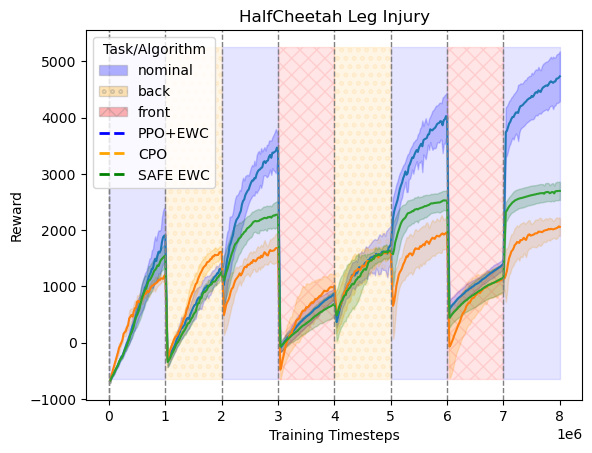

In [317]:
TASK_CYCLE = ['nominal', 'back', 'nominal', 'front', 'back', 'nominal', 'front']
algorithms = ['PPO+EWC', 'CPO', 'Safe EWC']
algorithm_colors={'PPO+EWC': 'blue', 
                  'CPO': 'orange',
                  'Safe EWC': 'green'}
cycle_colors = {
    'nominal': 'blue',
    'back': 'orange',
    'front': 'red'
}

cycle_hatches = {
    'nominal': '',
    'back': 'oo',
    'front': 'xx'
}

plt.plot(cheetah_cpo_0['Train/TotalSteps'], cheetah_ewc_mean_rewards, label='PPO+EWC')
plt.fill_between(
    cheetah_cpo_0['Train/TotalSteps'],
    cheetah_ewc_mean_rewards - cheetah_ewc_std_rewards,
    cheetah_ewc_mean_rewards + cheetah_ewc_std_rewards,
    color='blue', alpha=0.2
)

plt.plot(cheetah_cpo_0['Train/TotalSteps'], cheetah_cpo_mean_rewards, label='CPO')
plt.fill_between(
    cheetah_cpo_0['Train/TotalSteps'],
    cheetah_cpo_mean_rewards - cheetah_cpo_std_rewards,
    cheetah_cpo_mean_rewards + cheetah_cpo_std_rewards,
    color='orange', alpha=0.2
)

plt.plot(cheetah_cpo_0['Train/TotalSteps'], safe_ewc_mean_rewards, label='Safe EWC')
plt.fill_between(
    cheetah_cpo_0['Train/TotalSteps'],
    safe_ewc_mean_rewards - safe_ewc_std_rewards,
    safe_ewc_mean_rewards + safe_ewc_std_rewards,
    color='green', alpha=0.2
)

x_vals = range(0, max(cheetah_cpo_0['Train/TotalSteps']) + 1, 1000000)
for i, x in enumerate(x_vals[:-1]):  # Exclude the last x-value as it doesn't define a region
    # Get the current task from the cycle
    task = TASK_CYCLE[i % len(TASK_CYCLE)]
    
    # Shade the region between the current and next x value
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=1)
    plt.fill_between([x, x_vals[i + 1]], cheetah_ewc_0['Metrics/EpRet'].min(), cheetah_ewc_0['Metrics/EpRet'].max(), color=cycle_colors[task],  hatch=cycle_hatches[task], alpha=0.1)

plt.axvline(x=0, color='gray', linestyle='--', linewidth=1, label='Task Change')

legend_patches = []
for task in cycle_colors:
    patch = mpatches.Patch(
        facecolor=cycle_colors[task], 
        hatch=cycle_hatches[task], 
        label=task,
        edgecolor='gray',  # Optional: add edgecolor to improve visibility in legend,
        alpha=0.3
    )
    legend_patches.append(patch)

for algorithm in algorithms:
    custom_line = Line2D([0], [0], color=algorithm_colors[algorithm], lw=2, linestyle='--', label=algorithm.upper())
    legend_patches.append(custom_line)
# Add legend to the plot
plt.legend(handles=legend_patches, title='Task/Algorithm')

plt.xlabel("Training Timesteps")
plt.ylabel("Reward")
plt.title("HalfCheetah Leg Injury")

([<matplotlib.axis.XTick at 0x7fdcb492ffd0>,
 [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3')])

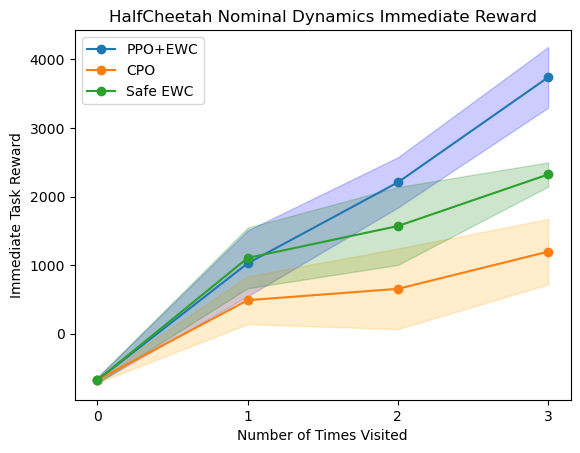

In [318]:
task_idx = [0, 101, 251, 351]
plt.plot(cheetah_ewc_mean_rewards[task_idx], marker='o', label='PPO+EWC')
plt.fill_between(
    [0, 1, 2, 3],
    cheetah_ewc_mean_rewards[task_idx] - cheetah_ewc_std_rewards[task_idx],
    cheetah_ewc_mean_rewards[task_idx] + cheetah_ewc_std_rewards[task_idx],
    color='blue', alpha=0.2
)

plt.plot(cheetah_cpo_mean_rewards[task_idx], marker='o', label='CPO')
plt.fill_between(
    [0, 1, 2, 3],
    cheetah_cpo_mean_rewards[task_idx] - cheetah_cpo_std_rewards[task_idx],
    cheetah_cpo_mean_rewards[task_idx] + cheetah_cpo_std_rewards[task_idx],
    color='orange', alpha=0.2
)

plt.plot(safe_ewc_mean_rewards[task_idx], marker='o', label='Safe EWC')
plt.fill_between(
    [0, 1, 2, 3],
    safe_ewc_mean_rewards[task_idx] - safe_ewc_std_rewards[task_idx],
    safe_ewc_mean_rewards[task_idx] + safe_ewc_std_rewards[task_idx],
    color='green', alpha=0.2
)

plt.xlabel("Number of Times Visited")
plt.ylabel("Immediate Task Reward")
plt.title("HalfCheetah Nominal Dynamics Immediate Reward")
plt.legend()
plt.xticks([0,1,2,3])

([<matplotlib.axis.XTick at 0x7fdcb492e7d0>,
 [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3')])

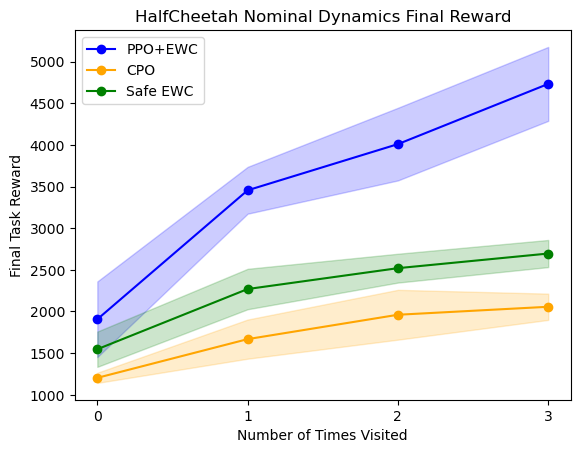

In [319]:
task_idx = [49, 149, 299, 399]
plt.plot(cheetah_ewc_mean_rewards[task_idx], marker='o', label='PPO+EWC', color='blue')
plt.fill_between(
    [0, 1, 2, 3],
    cheetah_ewc_mean_rewards[task_idx] - cheetah_ewc_std_rewards[task_idx],
    cheetah_ewc_mean_rewards[task_idx] + cheetah_ewc_std_rewards[task_idx],
    color='blue', alpha=0.2
)

plt.plot(cheetah_cpo_mean_rewards[task_idx], marker='o', label='CPO', color='orange')
plt.fill_between(
    [0, 1, 2, 3],
    cheetah_cpo_mean_rewards[task_idx] - cheetah_cpo_std_rewards[task_idx],
    cheetah_cpo_mean_rewards[task_idx] + cheetah_cpo_std_rewards[task_idx],
    color='orange', alpha=0.2
)

plt.plot(safe_ewc_mean_rewards[task_idx], marker='o', label='Safe EWC', color='green')
plt.fill_between(
    [0, 1, 2, 3],
    safe_ewc_mean_rewards[task_idx] - safe_ewc_std_rewards[task_idx],
    safe_ewc_mean_rewards[task_idx] + safe_ewc_std_rewards[task_idx],
    color='green', alpha=0.2
)

plt.xlabel("Number of Times Visited")
plt.ylabel("Final Task Reward")
plt.title("HalfCheetah Nominal Dynamics Final Reward")
plt.legend()
plt.xticks([0,1,2,3])

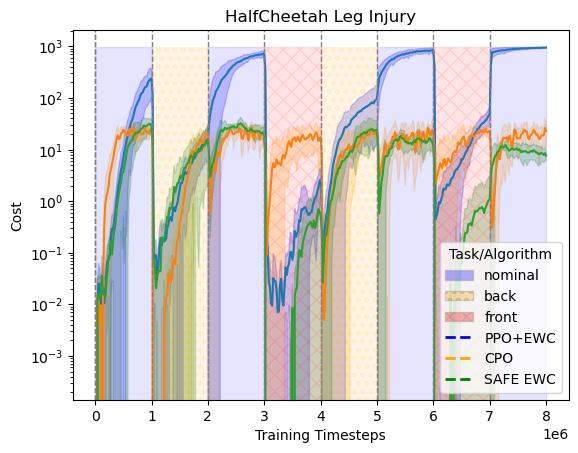

In [320]:
TASK_CYCLE = ['nominal', 'back', 'nominal', 'front', 'back', 'nominal', 'front']
algorithms = ['PPO+EWC', 'CPO', 'Safe EWC']
algorithm_colors={'PPO+EWC': 'blue', 
                  'CPO': 'orange',
                  'Safe EWC': 'green'}
cycle_colors = {
    'nominal': 'blue',
    'back': 'orange',
    'front': 'red'
}

cycle_hatches = {
    'nominal': '',
    'back': 'oo',
    'front': 'xx'
}

plt.plot(cheetah_cpo_0['Train/TotalSteps'], cheetah_ewc_mean_costs, label='PPO+EWC')
plt.fill_between(
    cheetah_cpo_0['Train/TotalSteps'],
    cheetah_ewc_mean_costs - cheetah_ewc_std_costs,
    cheetah_ewc_mean_costs + cheetah_ewc_std_costs,
    color='blue', alpha=0.2
)

plt.plot(cheetah_cpo_0['Train/TotalSteps'], cheetah_cpo_mean_costs, label='CPO')
plt.fill_between(
    cheetah_cpo_0['Train/TotalSteps'],
    cheetah_cpo_mean_costs - cheetah_cpo_std_costs,
    cheetah_cpo_mean_costs + cheetah_cpo_std_costs,
    color='orange', alpha=0.2
)

plt.plot(cheetah_cpo_0['Train/TotalSteps'], safe_ewc_mean_costs, label='Safe EWC')
plt.fill_between(
    cheetah_cpo_0['Train/TotalSteps'],
    safe_ewc_mean_costs - safe_ewc_std_costs,
    safe_ewc_mean_costs + safe_ewc_std_costs,
    color='green', alpha=0.2
)

x_vals = range(0, max(cheetah_cpo_0['Train/TotalSteps']) + 1, 1000000)
for i, x in enumerate(x_vals[:-1]):  # Exclude the last x-value as it doesn't define a region
    # Get the current task from the cycle
    task = TASK_CYCLE[i % len(TASK_CYCLE)]
    
    # Shade the region between the current and next x value
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=1)
    plt.fill_between([x, x_vals[i + 1]], cheetah_ewc_0['Metrics/EpCost'].min(), cheetah_ewc_0['Metrics/EpCost'].max(), color=cycle_colors[task],  hatch=cycle_hatches[task], alpha=0.1)

plt.axvline(x=0, color='gray', linestyle='--', linewidth=1, label='Task Change')

legend_patches = []
for task in cycle_colors:
    patch = mpatches.Patch(
        facecolor=cycle_colors[task], 
        hatch=cycle_hatches[task], 
        label=task,
        edgecolor='gray',  # Optional: add edgecolor to improve visibility in legend,
        alpha=0.3
    )
    legend_patches.append(patch)

for algorithm in algorithms:
    custom_line = Line2D([0], [0], color=algorithm_colors[algorithm], lw=2, linestyle='--', label=algorithm.upper())
    legend_patches.append(custom_line)
# Add legend to the plot
plt.legend(handles=legend_patches, title='Task/Algorithm')

plt.xlabel("Training Timesteps")
plt.ylabel("Cost")
plt.title("HalfCheetah Leg Injury")
plt.yscale("log")

# Ant Results

In [321]:
ant_cpo_0 = pd.read_csv('./results/ant_cpo_seed0.csv')
ant_cpo_1 = pd.read_csv('./results/ant_cpo_seed1.csv')
ant_cpo_2 = pd.read_csv('./results/ant_cpo_seed2.csv')
ant_cpo_3 = pd.read_csv('./results/ant_cpo_seed3.csv')
ant_cpo_4 = pd.read_csv('./results/ant_cpo_seed4.csv')

cpo_list = [ant_cpo_0, ant_cpo_1, ant_cpo_2, ant_cpo_3, ant_cpo_4]

ant_cpo_rewards = [results['Metrics/EpRet'] for results in cpo_list]
ant_cpo_costs = [results['Metrics/EpCost'] for results in cpo_list]

ant_cpo_mean_rewards = np.mean(ant_cpo_rewards, axis=0)
ant_cpo_mean_costs = np.mean(ant_cpo_costs, axis=0)

ant_cpo_std_rewards = np.std(ant_cpo_rewards, axis=0)
ant_cpo_std_costs = np.std(ant_cpo_costs, axis=0)

aggregate_metrics(cpo_list, tasks_encountered, 50)

COSTS:
Nominal total costs: 873.6011764376375 +/- 78.36792689796104
Back total costs: 913.9195725108224 +/- 144.67559168931888
Front total costs: 871.6341125541127 +/- 34.05009028646475
FORGETTING RATIO:
Nominal forgetting: 15.133153670825157 +/- 11.512019212495597
Back forgetting: 50.82983669823644 +/- 20.239928215073366
Front forgetting: 44.3612321642049 +/- 17.9309476379429
REWARDS:
Nominal rewards: 2901.446350042246 +/- 59.000848471182216
Back rewards: 2634.486725798538 +/- 141.75652573259725
Front rewards: 2590.2050122758856 +/- 152.3150138080066


In [322]:
ant_ewc_0 = pd.read_csv('./results/ppo_ewc_ant0.csv')
ant_ewc_1 = pd.read_csv('./results/ppo_ewc_ant1.csv')
ant_ewc_2 = pd.read_csv('./results/ppo_ewc_ant2.csv')
ant_ewc_3 = pd.read_csv('./results/ppo_ewc_ant3.csv')
ant_ewc_4 = pd.read_csv('./results/ppo_ewc_ant4.csv')

ewc_list = [ant_ewc_0, ant_ewc_1, ant_ewc_2, ant_ewc_3, ant_ewc_4]

ant_ewc_rewards = [results['Metrics/EpRet'] for results in ewc_list]
ant_ewc_costs = [results['Metrics/EpCost'] for results in ewc_list]

ant_ewc_mean_rewards = np.mean(ant_ewc_rewards, axis=0)
ant_ewc_mean_costs = np.mean(ant_ewc_costs, axis=0)

ant_ewc_std_rewards = np.std(ant_ewc_rewards, axis=0)
ant_ewc_std_costs = np.std(ant_ewc_costs, axis=0)

aggregate_metrics(ewc_list, tasks_encountered, 50)


COSTS:
Nominal total costs: 11543.364434915993 +/- 4563.003558025804
Back total costs: 2551.1247284226642 +/- 2308.2100423228076
Front total costs: 6846.527845238097 +/- 3215.7443829886956
FORGETTING RATIO:
Nominal forgetting: -402.1948479021717 +/- 173.88991653887751
Back forgetting: -7.004231692744421 +/- 19.493061298782855
Front forgetting: 21.220373307020402 +/- 12.676061223264778
REWARDS:
Nominal rewards: 3972.7669680211047 +/- 487.40888579892055
Back rewards: 2407.230049333718 +/- 320.0793518833276
Front rewards: 3103.0678139410456 +/- 228.2830954231226


In [323]:
safe_ewc_ant0 = convert_reward(pd.read_csv('./results/safe_ewc_ant0.csv'))
safe_ewc_ant1 = convert_reward(pd.read_csv('./results/safe_ewc_ant1.csv'))
safe_ewc_ant2 = convert_reward(pd.read_csv('./results/safe_ewc_ant2.csv'))
safe_ewc_ant3 = convert_reward(pd.read_csv('./results/safe_ewc_ant3.csv'))
safe_ewc_ant4 = convert_reward(pd.read_csv('./results/safe_ewc_ant4.csv'))

safe_ewc_antlist = [safe_ewc_ant0, safe_ewc_ant1, safe_ewc_ant2, safe_ewc_ant3, safe_ewc_ant4]

safe_ewc_antrewards = [results['Metrics/EpRet'] for results in safe_ewc_antlist]
safe_ewc_antcosts = [results['Metrics/EpCost'] for results in safe_ewc_antlist]

safe_ewc_mean_rewards = np.mean(safe_ewc_antrewards, axis=0)
safe_ewc_mean_costs = np.mean(safe_ewc_antcosts, axis=0)
safe_ewc_mean_rewards += 5 * safe_ewc_mean_costs # add it back to make reward same as other tasks

safe_ewc_std_rewards = np.std(safe_ewc_antrewards, axis=0)
safe_ewc_std_costs = np.std(safe_ewc_antcosts, axis=0)

aggregate_metrics(safe_ewc_antlist, tasks_encountered, 50)

COSTS:
Nominal total costs: 323.00441890896934 +/- 30.080933036752246
Back total costs: 218.2058883753927 +/- 85.62901655519536
Front total costs: 304.82860714285715 +/- 102.71442528652462
FORGETTING RATIO:
Nominal forgetting: -507.2217449843741 +/- 186.92201818992189
Back forgetting: -16.73945789729085 +/- 7.408305724595293
Front forgetting: 31.887614389084774 +/- 12.98367228374614
REWARDS:
Nominal rewards: 2880.764669219585 +/- 52.64643159090931
Back rewards: 2319.1868758975097 +/- 89.84202025100814
Front rewards: 2739.2381925396016 +/- 69.08430964941519


Text(0.5, 1.0, 'Ant Leg Injury')

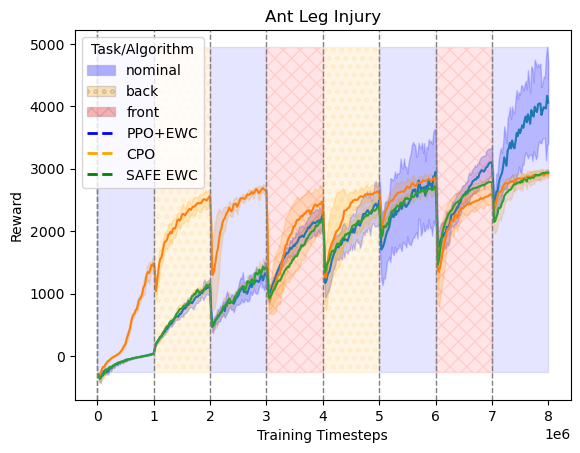

In [324]:
TASK_CYCLE = ['nominal', 'back', 'nominal', 'front', 'back', 'nominal', 'front']
algorithms = ['PPO+EWC', 'CPO', 'Safe EWC']
algorithm_colors={'PPO+EWC': 'blue', 
                  'CPO': 'orange',
                  'Safe EWC': 'green'}
cycle_colors = {
    'nominal': 'blue',
    'back': 'orange',
    'front': 'red'
}

cycle_hatches = {
    'nominal': '',
    'back': 'oo',
    'front': 'xx'
}

plt.plot(ant_cpo_0['Train/TotalSteps'], ant_ewc_mean_rewards, label='PPO+EWC')
plt.fill_between(
    ant_cpo_0['Train/TotalSteps'],
    ant_ewc_mean_rewards - ant_ewc_std_rewards,
    ant_ewc_mean_rewards + ant_ewc_std_rewards,
    color='blue', alpha=0.2
)

plt.plot(ant_cpo_0['Train/TotalSteps'], ant_cpo_mean_rewards, label='CPO')
plt.fill_between(
    ant_cpo_0['Train/TotalSteps'],
    ant_cpo_mean_rewards - ant_cpo_std_rewards,
    ant_cpo_mean_rewards + ant_cpo_std_rewards,
    color='orange', alpha=0.2
)

plt.plot(ant_cpo_0['Train/TotalSteps'], safe_ewc_mean_rewards, label='CPO')
plt.fill_between(
    ant_cpo_0['Train/TotalSteps'],
    safe_ewc_mean_rewards - safe_ewc_std_rewards,
    safe_ewc_mean_rewards + safe_ewc_std_rewards,
    color='orange', alpha=0.2
)

x_vals = range(0, max(ant_cpo_0['Train/TotalSteps']) + 1, 1000000)
for i, x in enumerate(x_vals[:-1]):  # Exclude the last x-value as it doesn't define a region
    # Get the current task from the cycle
    task = TASK_CYCLE[i % len(TASK_CYCLE)]
    
    # Shade the region between the current and next x value
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=1)
    plt.fill_between([x, x_vals[i + 1]], ant_ewc_0['Metrics/EpRet'].min(), ant_ewc_0['Metrics/EpRet'].max(), color=cycle_colors[task],  hatch=cycle_hatches[task], alpha=0.1)

plt.axvline(x=0, color='gray', linestyle='--', linewidth=1, label='Task Change')

legend_patches = []
for task in cycle_colors:
    patch = mpatches.Patch(
        facecolor=cycle_colors[task], 
        hatch=cycle_hatches[task], 
        label=task,
        edgecolor='gray',  # Optional: add edgecolor to improve visibility in legend,
        alpha=0.3
    )
    legend_patches.append(patch)

for algorithm in algorithms:
    custom_line = Line2D([0], [0], color=algorithm_colors[algorithm], lw=2, linestyle='--', label=algorithm.upper())
    legend_patches.append(custom_line)
# Add legend to the plot
plt.legend(handles=legend_patches, title='Task/Algorithm')

plt.xlabel("Training Timesteps")
plt.ylabel("Reward")
plt.title("Ant Leg Injury")

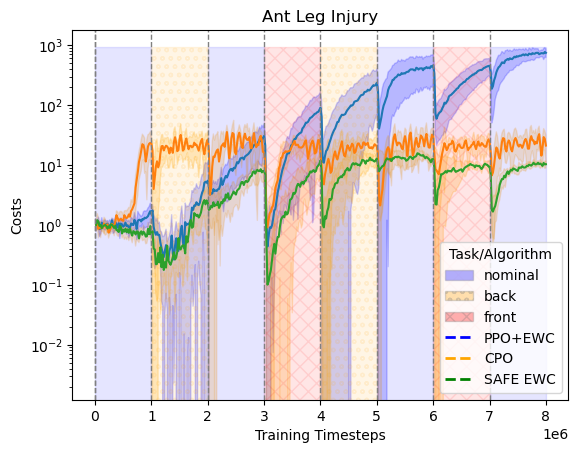

In [325]:
TASK_CYCLE = ['nominal', 'back', 'nominal', 'front', 'back', 'nominal', 'front']
algorithms = ['PPO+EWC', 'CPO', 'Safe EWC']
algorithm_colors={'PPO+EWC': 'blue', 
                  'CPO': 'orange',
                  'Safe EWC': 'green'}
cycle_colors = {
    'nominal': 'blue',
    'back': 'orange',
    'front': 'red'
}

cycle_hatches = {
    'nominal': '',
    'back': 'oo',
    'front': 'xx'
}

plt.plot(ant_cpo_0['Train/TotalSteps'], ant_ewc_mean_costs, label='PPO+EWC')
plt.fill_between(
    ant_cpo_0['Train/TotalSteps'],
    ant_ewc_mean_costs - ant_ewc_std_costs,
    ant_ewc_mean_costs + ant_ewc_std_costs,
    color='blue', alpha=0.2
)

plt.plot(ant_cpo_0['Train/TotalSteps'], ant_cpo_mean_costs, label='CPO')
plt.fill_between(
    ant_cpo_0['Train/TotalSteps'],
    ant_cpo_mean_costs - ant_cpo_std_costs,
    ant_cpo_mean_costs + ant_cpo_std_costs,
    color='orange', alpha=0.2
)

plt.plot(ant_cpo_0['Train/TotalSteps'], safe_ewc_mean_costs, label='CPO')
plt.fill_between(
    ant_cpo_0['Train/TotalSteps'],
    safe_ewc_mean_costs - safe_ewc_std_costs,
    safe_ewc_mean_costs + safe_ewc_std_costs,
    color='orange', alpha=0.2
)

x_vals = range(0, max(ant_cpo_0['Train/TotalSteps']) + 1, 1000000)
for i, x in enumerate(x_vals[:-1]):  # Exclude the last x-value as it doesn't define a region
    # Get the current task from the cycle
    task = TASK_CYCLE[i % len(TASK_CYCLE)]
    
    # Shade the region between the current and next x value
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=1)
    plt.fill_between([x, x_vals[i + 1]], ant_ewc_1['Metrics/EpCost'].min(), ant_ewc_0['Metrics/EpCost'].max(), color=cycle_colors[task],  hatch=cycle_hatches[task], alpha=0.1)

plt.axvline(x=0, color='gray', linestyle='--', linewidth=1, label='Task Change')

legend_patches = []
for task in cycle_colors:
    patch = mpatches.Patch(
        facecolor=cycle_colors[task], 
        hatch=cycle_hatches[task], 
        label=task,
        edgecolor='gray',  # Optional: add edgecolor to improve visibility in legend,
        alpha=0.3
    )
    legend_patches.append(patch)

for algorithm in algorithms:
    custom_line = Line2D([0], [0], color=algorithm_colors[algorithm], lw=2, linestyle='--', label=algorithm.upper())
    legend_patches.append(custom_line)
# Add legend to the plot
plt.legend(handles=legend_patches, title='Task/Algorithm')

plt.xlabel("Training Timesteps")
plt.ylabel("Costs")
plt.title("Ant Leg Injury")
plt.yscale("log")